# Experiment: Noise Floor and Accumulation

## Objective
Assessing the noise floor of the equipment and understand how accumulation help reducing the noise floor

In [1]:
from pathlib import Path
from raman.sample import read_txt, Sample
import matplotlib.pyplot as plt
import numpy as np

def add_plot_label():
    plt.xlabel("Raman Shift (cm^-1)")
    plt.ylabel("Intensity")
    plt.grid()

BASE_PATH:Path = Path("/app")

## 1. Noise Floor of 10 seconds

There 15 recordings of the noise floor of over 10 seconds.
We limit the range to interest region of [0-2000]

0 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_13_40_01.txt
1 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_12_37_01.txt
2 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_12_58_01.txt
3 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_11_53_01.txt
4 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_11_43_01.txt
5 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_12_15_01.txt
6 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_11_31_01.txt
7 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_12_47_01.txt
8 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_13_22_01.txt
Found 2 spike(s) in path=/app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_13_22_01.txt, self.remove_spike() is perform automatically.
9 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_14_10_01.txt
10 /app/data/noise/10s/txt/noise_600_785 nm_10 s_1_2024_12_09_12_12_26_01.txt
11 /a

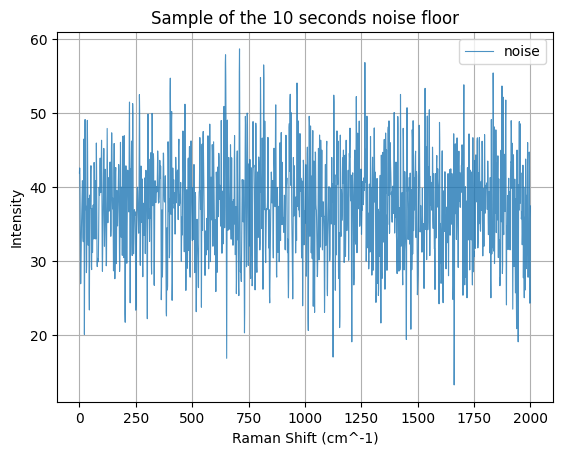

In [2]:
DATA_PATH:Path = BASE_PATH.joinpath("data/noise/10s/txt")
samples:list[Sample] = []
for i, path in enumerate(DATA_PATH.glob("*.txt")):
    print(i, path)
    sample = read_txt(path=path, verbose=True)
    sample.extract_range(low=0, high=2000)
    samples.append(sample)
samples[0].plot()
plt.title("Sample of the 10 seconds noise floor")
plt.legend()
add_plot_label()
plt.show()

In [3]:
print("id","Max","Min","Avg",sep="\t")
for idx, sample in enumerate(samples):
    print(idx, round(sample.y.max(), 2), round(sample.y.min(),2), round(sample.y.mean(),2)  ,sep="\t")


id	Max	Min	Avg
0	58.7	13.22	37.4
1	56.91	16.19	36.61
2	56.56	14.2	36.26
3	55.09	16.1	36.87
4	59.89	16.55	37.34
5	60.23	13.89	36.85
6	62.77	15.71	37.85
7	61.23	15.49	37.18
8	60.0	14.45	36.73
9	62.8	14.02	36.95
10	56.42	14.79	37.05
11	54.4	14.73	36.52
12	61.51	13.09	37.17
13	57.88	16.18	36.16
14	60.22	12.61	36.88


Let's find, expected Max, Min, and Avg

In [4]:
def get_stat(samples:list[Sample]) -> dict:
    expected_max = []
    expected_min = []
    expected_avg = []

    for idx, sample in enumerate(samples):
        expected_max.append(sample.y.max())
        expected_min.append(sample.y.min())
        expected_avg.append(sample.y.mean())

    expected_max = np.array(expected_max)
    expected_min = np.array(expected_min)
    expected_avg = np.array(expected_avg)
    ans = {
        "max": (round(expected_max.mean(),2), round(expected_max.std(),2)),
        "min": (round(expected_min.mean(),2), round(expected_min.std(),2)),
        "avg": (round(expected_avg.mean(),2), round(expected_avg.std(),2)),
    }
    return ans

ans = get_stat(samples)
print(f"For 10 seconds recording")
print(f"Expected Noise Floor")
print(f"Max = {ans['max'][0]}+-{ans['max'][1]}")
print(f"Min = {ans['min'][0]}+-{ans['min'][1]}")
print(f"Avg = {ans['avg'][0]}+-{ans['avg'][1]}")

For 10 seconds recording
Expected Noise Floor
Max = 58.97+-2.58
Min = 14.75+-1.21
Avg = 36.92+-0.43


## 2. Accumulation affects Noise Floor

Let's see how accumulation afftecs the noise floor.

Start with 2 accumulations.

In [5]:
# Do this will create an emulated accumulation.
samples[0] | samples[1]


  Sample: noise
    date: 2024-12-09 12:13:40
 grating: 600
   laser: 785 nm
exposure: 10 s
    accu: 2
    stat: Max=54.66 Min=23.48 Mean=37.0 Std=4.49

In [6]:
# a | b works with two paris which is fine for 2 accumulations.
# If more than 2 accumulations, we can make use of reduce()
from functools import reduce
reduce(lambda a,b: a | b,  [samples[4], samples[5], samples[6]] )


  Sample: noise
    date: 2024-12-09 12:11:43
 grating: 600
   laser: 785 nm
exposure: 10 s
    accu: 3
    stat: Max=49.77 Min=26.22 Mean=37.35 Std=3.66

In [7]:
# To select samples with a index list, we can use map()
reduce(lambda a,b: a | b,  
       map(samples.__getitem__, [4,5,6]) )



  Sample: noise
    date: 2024-12-09 12:11:43
 grating: 600
   laser: 785 nm
exposure: 10 s
    accu: 3
    stat: Max=49.77 Min=26.22 Mean=37.35 Std=3.66

In [8]:
def accum(samples:list[Sample], idxes:list[int]):
    return reduce(lambda a,b: a | b,  
       map(samples.__getitem__, idxes) )
accum(samples, [4,5,6])


  Sample: noise
    date: 2024-12-09 12:11:43
 grating: 600
   laser: 785 nm
exposure: 10 s
    accu: 3
    stat: Max=49.77 Min=26.22 Mean=37.35 Std=3.66

In [9]:
# We can create all possible combination using combinations()
from itertools import combinations
list(combinations(range(15), 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (9, 10),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (11, 12),
 (11, 13),
 (11, 14),
 (12, 13),
 (12, 1

In [10]:
# create all possible pairs from 15 samples.
samples_2:list[Sample] = []
for idxes in combinations(range(15), 2): 
    sample = accum(samples, idxes)
    samples_2.append(sample)

ans = get_stat(samples_2)
print(f"For 10 seconds recording with 2 accumulations")
print(f"Expected Noise Floor")
print(f"Max = {ans['max'][0]}+-{ans['max'][1]}")
print(f"Min = {ans['min'][0]}+-{ans['min'][1]}")
print(f"Avg = {ans['avg'][0]}+-{ans['avg'][1]}")

For 10 seconds recording with 2 accumulations
Expected Noise Floor
Max = 52.79+-1.41
Min = 21.22+-1.76
Avg = 36.92+-0.29


In [11]:
# Now, we will do that for all layers and kept the answer in the answers
answers:list[dict] = []
for layer in range(15):
    layer_samples:list[Sample] = []
    for idxes in combinations(range(15), layer+1):
        layer_samples.append(accum(samples, idxes))
    print(layer+1, len(layer_samples))
    ans = get_stat(layer_samples)
    answers.append(ans)

len(answers)


1 15
2 105
3 455
4 1365
5 3003
6 5005
7 6435
8 6435
9 5005
10 3003
11 1365
12 455
13 105
14 15
15 1


15

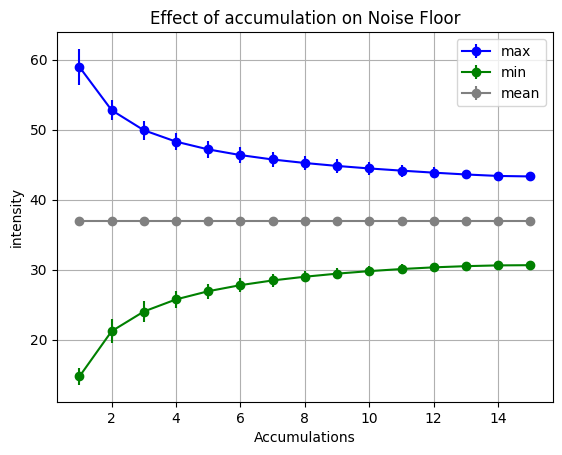

Accumu	Ampli	std	reduct	ratio (%)
1	44.22	3.79	0.0	0.0
2	31.57	3.17	12.65	28.61
3	25.9	2.79	18.32	41.43
4	22.54	2.49	21.68	49.03
5	20.26	2.26	23.96	54.18
6	18.58	2.09	25.64	57.98
7	17.28	1.95	26.94	60.92
8	16.25	1.84	27.97	63.25
9	15.39	1.73	28.83	65.2
10	14.67	1.63	29.55	66.82
11	14.06	1.54	30.16	68.2
12	13.53	1.44	30.69	69.4
13	13.1	1.28	31.12	70.38
14	12.78	0.99	31.44	71.1
15	12.68	0.0	31.54	71.33


In [12]:
def report(title:str, answers:list[dict]):
    plt.title(title)
    maxes_avg = []
    maxes_std = []
    mins_avg = []
    mins_std = []
    means_avg = []
    means_std = []

    for i in range(15):
        maxes_avg.append(answers[i]['max'][0])
        maxes_std.append(answers[i]['max'][1])
        mins_avg.append(answers[i]['min'][0])
        mins_std.append(answers[i]['min'][1])
        means_avg.append(answers[i]['avg'][0])
        means_std.append(answers[i]['avg'][1])

    plt.errorbar(x=range(1,16), y=maxes_avg, yerr=maxes_std, marker='o', color='blue', label="max")
    plt.errorbar(x=range(1,16), y=mins_avg, yerr=mins_std, marker='o', color='green', label="min")
    plt.errorbar(x=range(1,16), y=means_avg, yerr=means_std, marker='o', color='grey', label="mean")

    plt.xlabel(f"Accumulations")
    plt.ylabel(f"intensity")
    plt.legend()
    plt.grid()
    plt.show()

    print("Accumu", "Ampli", "std", "reduct", "ratio (%)", sep='\t')
    default = 0
    for i in range(15):
        amp = maxes_avg[i] - mins_avg[i]
        std = maxes_std[i] + mins_std[i]
        if(i == 0):
            default = amp
        reduct = default-amp
        ratio = reduct / default * 100
        print(i+1, round(amp,2), round(std,2), round(reduct,2), round(ratio,2), sep='\t')



report(title="Effect of accumulation on Noise Floor", answers=answers)

## Is it still true for longer exposure?

Let's explore the measurement that has an exposure longer than 10 seconds.

0 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_22_40_01.txt
Found 1 spike(s) in path=/app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_22_40_01.txt, self.remove_spike() is perform automatically.
1 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_20_04_01.txt
2 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_19_02_01.txt
3 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_21_06_01.txt
Found 1 spike(s) in path=/app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_21_06_01.txt, self.remove_spike() is perform automatically.
4 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_16_23_01.txt
Found 1 spike(s) in path=/app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_16_23_01.txt, self.remove_spike() is perform automatically.
5 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_15_49_01.txt
6 /app/data/noise/30s/txt/noise_600_785 nm_30 s_1_2024_12_09_12_21_37_01.txt
Found 1 spike(s) in 

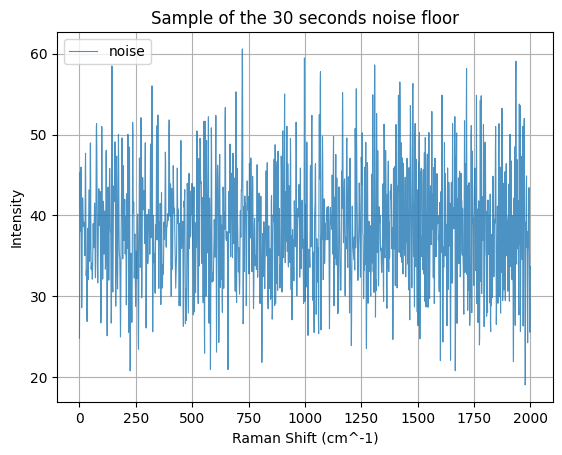

In [13]:
# Exposure of 30 seconds
samples_30s:list[Sample] = []
for i, path in enumerate(BASE_PATH.joinpath("data/noise/30s/txt/").glob("*.txt")):
    print(i, path)
    sample = read_txt(path=path, verbose=True)
    sample.extract_range(low=0, high=2000)
    samples_30s.append(sample)
samples_30s[0].plot()
plt.title("Sample of the 30 seconds noise floor")
plt.legend()
add_plot_label()
plt.show()

In [14]:
# Now, we will do that for all layers and kept the answer in the answers
answers_30s:list[dict] = []
for layer in range(15):
    layer_samples:list[Sample] = []
    for idxes in combinations(range(15), layer+1):
        layer_samples.append(accum(samples_30s, idxes))
    # print(layer+1, len(layer_samples))
    ans = get_stat(layer_samples)
    answers_30s.append(ans)

len(answers_30s)

15

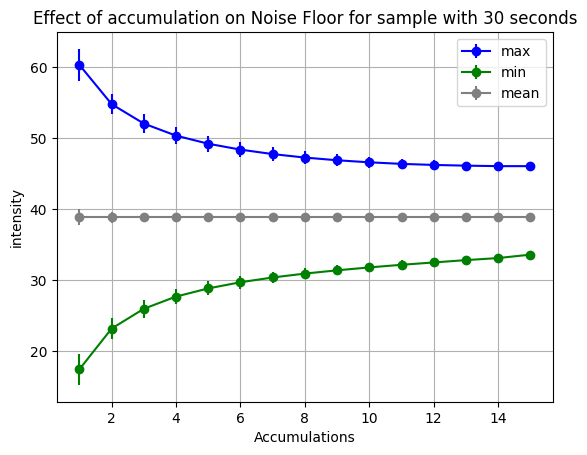

Accumu	Ampli	std	reduct	ratio (%)
1	42.91	4.47	0.0	0.0
2	31.64	2.87	11.27	26.26
3	26.11	2.61	16.8	39.15
4	22.69	2.33	20.22	47.12
5	20.4	2.09	22.51	52.46
6	18.7	1.91	24.21	56.42
7	17.4	1.76	25.51	59.45
8	16.36	1.65	26.55	61.87
9	15.52	1.54	27.39	63.83
10	14.82	1.44	28.09	65.46
11	14.23	1.33	28.68	66.84
12	13.75	1.19	29.16	67.96
13	13.32	1.02	29.59	68.96
14	12.96	0.73	29.95	69.8
15	12.48	0.0	30.43	70.92


In [15]:
report(title="Effect of accumulation on Noise Floor for sample with 30 seconds", answers=answers_30s)

0 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_26_16_01.txt
1 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_37_39_01.txt
2 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_34_32_01.txt
Found 1 spike(s) in path=/app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_34_32_01.txt, self.remove_spike() is perform automatically.
3 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_29_23_01.txt
Found 2 spike(s) in path=/app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_29_23_01.txt, self.remove_spike() is perform automatically.
4 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_35_34_01.txt
5 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_41_13_01.txt
6 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_36_37_01.txt
7 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_32_28_01.txt
8 /app/data/noise/60s/txt/noise_600_785 nm_60 s_1_2024_12_09_12_31_26_01.txt
9 /app/data/n

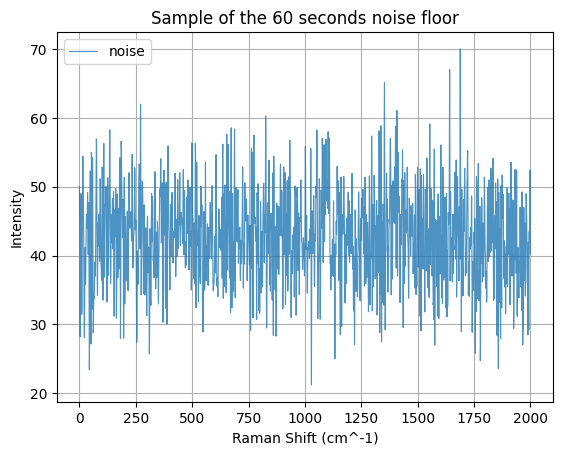

In [16]:
# Exposure of 60 seconds
samples_60s:list[Sample] = []
for i, path in enumerate(BASE_PATH.joinpath("data/noise/60s/txt/").glob("*.txt")):
    print(i, path)
    sample = read_txt(path=path, verbose=True)
    sample.extract_range(low=0, high=2000)
    samples_60s.append(sample)
samples_60s[0].plot()
plt.title("Sample of the 60 seconds noise floor")
plt.legend()
add_plot_label()
plt.show()

In [17]:
# Now, we will do that for all layers and kept the answer in the answers
answers_60s:list[dict] = []
for layer in range(15):
    layer_samples:list[Sample] = []
    for idxes in combinations(range(15), layer+1):
        layer_samples.append(accum(samples_60s, idxes))
    # print(layer+1, len(layer_samples))
    ans = get_stat(layer_samples)
    answers_60s.append(ans)

len(answers_60s)

15

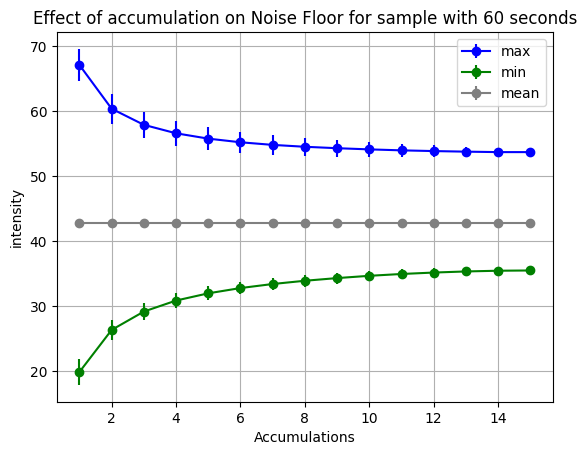

Accumu	Ampli	std	reduct	ratio (%)
1	47.15	4.46	0.0	0.0
2	33.97	3.84	13.18	27.95
3	28.68	3.27	18.47	39.17
4	25.69	3.02	21.46	45.51
5	23.76	2.8	23.39	49.61
6	22.39	2.61	24.76	52.51
7	21.37	2.45	25.78	54.68
8	20.58	2.29	26.57	56.35
9	19.95	2.14	27.2	57.69
10	19.42	1.98	27.73	58.81
11	18.99	1.82	28.16	59.72
12	18.66	1.63	28.49	60.42
13	18.4	1.41	28.75	60.98
14	18.22	1.07	28.93	61.36
15	18.18	0.0	28.97	61.44


In [18]:
report(title="Effect of accumulation on Noise Floor for sample with 60 seconds", answers=answers_60s)

## Conclusion

The expected amplitude of 1 accumulation is 44.22+-3.79 which means it could be as high as 44.22 + 3.79 = 48.01.

With 4 accumulations, the expected amplitude is reduced by 49.03% to 22.54+-2.49.

To beat the noise floor, the scattering should be larger than the expected max in the accumulation.

However, the reduction of noise floor is rarely improve after 4 accumulations.